**Note!** The generated data comes in the shape of (batch size, time series length, no. features). This means that if we want to visualize one batch of data, we do `data[0].T`. Tranpose is important to put features as rows to show multivariate data correctly!

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch as th
from pytorch_lightning import seed_everything

SEED = 42

In [77]:
import pickle
from experiments.hmm.classifier import StateClassifier, StateClassifierNet


def get_classifier(experiment):
    if experiment == "hmm":
        # From HMM experiments
        classifier = StateClassifierNet(
            feature_size=3,
            n_state=2,
            hidden_size=200,
            regres=True,
            loss="cross_entropy",
            lr=0.0001,
            l2=1e-3,
        )
        checkpoint = "models/hmm_42_classifier.ckpt"

        classifier.load_state_dict(th.load(checkpoint))

    return classifier


def save_explainer(explainer, explainer_name="explainer"):
    with open(f"{explainer_name}.pkl", "wb") as f:
        pickle.dump(explainer, f)


def load_explainer(explainer_name="explainer", experiment="hmm"):
    attr = None
    mask_net = None
    ecl_inputsplainer = None
    perturbation_net = None
    classifier = None

    # if experiment == "hmm":
    #     # classifier = get_classifier("hmm")
    #     with open(f"{explainer_name}_perturbation_net.pkl", "rb") as f:
    #         perturbation_net = pickle.load(f)

    with open(f"{explainer_name}_attr.pkl", "rb") as f:
        attr = pickle.load(f)

    with open(f"{explainer_name}_explainer.pkl", "rb") as f:
        ecl_inputsplainer = pickle.load(f)

    with open(f"{explainer_name}_mask_net.pkl", "rb") as f:
        mask_net = pickle.load(f)

    return attr, mask_net, ecl_inputsplainer, perturbation_net, classifier

In [78]:
# Adopted from https://github.com/fzi-forschungszentrum-informatik/TSInterpret/blob/main/TSInterpret/InterpretabilityModels/Saliency/Saliency_Base.py
def plot_saliency(ts_data, perturbed, saliency_list, figsize=None, suptitle=None):
    plt.style.use("default")

    if figsize is None:
        figsize = (10, len(ts_data) * 1.2)

    fig, axn = plt.subplots(len(ts_data), 1, sharex=True, sharey=True, figsize=figsize)
    cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])

    for i, channel in enumerate(ts_data):
        axn012 = axn[i].twinx()

        # Plot saliency
        sns.heatmap(
            saliency_list[i].reshape(1, -1),
            fmt="g",
            cmap="viridis",
            cbar=i == 0,
            cbar_ax=None if i else cbar_ax,
            cbar_kws={"label": "Saliency / Mask intensity"},
            ax=axn[i],
            yticklabels=False,
            vmin=0,
            vmax=1,
        )

        xs = range(0, len(channel.reshape(-1)))
        # Plot learned perturbations
        axn012.plot(
            xs,
            perturbed[i].detach().numpy(),
            color="red",
            label="Perturbed data",
            marker=".",
        )
        # Plot original data
        axn012.plot(
            xs, channel.flatten(), color="#91BBDE", label="Original data", marker="."
        )

        plt.xlabel("Time", fontweight="bold", fontsize="large")
        plt.ylabel(f"Feature {i}", fontweight="bold", fontsize="large")
    plt.legend()
    fig.tight_layout(rect=[0, 0, 0.9, 1])
    fig.suptitle(suptitle, y=1.01)
    plt.show()


# Adapted from appendix of https://arxiv.org/abs/2106.05303
def plot_heatmap(saliencies, figsize=None):
    plt.style.use("default")
    N = len(saliencies)
    if figsize is None:
        figsize = (10, N * 2)

    fig, axn = plt.subplots(
        int(np.ceil(N / 2)), 2, sharex=True, sharey=True, figsize=figsize
    )
    axn = axn.flatten()
    cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])

    color_map = sns.diverging_palette(10, 133, as_cmap=True)

    for idx, (method, saliency) in enumerate(saliencies.items()):
        sns.heatmap(
            saliency,
            cmap=color_map,
            cbar=idx == 0,
            cbar_ax=None if idx else cbar_ax,
            cbar_kws={"label": "Saliency / Mask intensity"},
            ax=axn[idx],
            yticklabels=False,
            linecolor="#d8cbd5",
            linewidths=0.4,
            vmin=0,
            vmax=1,
        )
        axn[idx].set_title(f"Method: {method}")
        axn[idx].set_xlabel("Time")
        axn[idx].set_ylabel("Feature number")

    fig.suptitle("Mask coefficients over time")
    fig.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

In [79]:
def plot_components(
    orig, perturbed, mask, perturbation, suptitle=None, figsize=(10, 6)
):
    plt.style.use("ggplot")
    plt.rcParams.update({"axes.titlesize": "medium"})

    fig, axs = plt.subplots(5, 1, figsize=figsize)

    orig = orig.flatten().numpy()
    perturbed = perturbed.detach().numpy()
    mask = mask.detach().numpy()
    perturbation = perturbation.detach().numpy()

    xs = range(0, len(orig.reshape(-1)))
    axs[0].plot(xs, mask, marker=".")
    axs[0].set_title("Learned mask/saliency: m")

    axs[1].plot(xs, perturbation, marker=".")
    axs[1].set_title(
        "Learned perturbation: NN(x)",
    )

    axs[2].plot(xs, mask * orig, marker=".")
    axs[2].set_title("m * x")

    axs[3].plot(xs, (1 - mask) * perturbation, marker=".")
    axs[3].set_title("(1 - m) * NN(x)")

    axs[4].plot(xs, perturbed, label="m * x + (1 - m) * NN(x)", marker=".")
    axs[4].plot(xs, orig, label="Original data", marker=".")
    axs[4].set_title("Perturbed vs Original data")
    axs[4].legend(fontsize=7)

    plt.xlabel("Time", fontweight="bold")
    plt.suptitle(suptitle)
    fig.tight_layout()
    plt.show()

In [80]:
def compute_perturbations(
    data, mask_net, perturb_net=None, batch_idx: int = 0
) -> (th.Tensor, th.Tensor, th.Tensor, th.Tensor, th.Tensor):
    """Use the trained mask network to compute perturbations and their intermediate results.

    This function only works for explainer methods that train a mask network. Such methods include DynaMask and ExtremalMask.

    :param data: all data to be investigated. A subset of it will be investigated depending on the batch_idx and batch_size of the mask_net
    :param mask_net: the trained mask network
    :param perturb_net: the trained perturbation network. You can usually access it via mask_net.net.model. Defaults to None in which case the baseline will be zeroes
    :param batch_idx: the batch number to investigate, batch size will be inferred from mask_net. Defaults to 0
    :return: a 5-tuple:
    - tensor of the batch of data that was used for calculation
    - tensor of perturbations predicted by perturb_net (or defaulted to)
    - tensor of the predicted mask by mask_net
    - tensor of inputs with important features masked, i.e. from the paper: data * mask + (1 - mask) * NN(data)
    - tensor of inputs with unimportant features masked, i.e.: data * (1 - mask) + NN(data) * data
    """

    batch_size = mask_net.net.batch_size
    FROM_B = batch_size * batch_idx
    TO_B = batch_size * (batch_idx + 1)
    batch = data[FROM_B:TO_B]

    # If there is a model, NN(x), that predicts perturbations, use it
    # Otherwise, default to zeroes
    baseline = perturb_net(batch) if perturb_net is not None else th.zeros_like(batch)

    # Retrieve the learned mask for the batch in question
    mask = mask_net.net.mask
    mask = mask[FROM_B:TO_B]
    mask = mask.clamp(0, 1)

    # Mask data according to samples
    # We eventually cut samples up to x time dimension
    # x1 represents inputs with important features masked.
    # x2 represents inputs with unimportant features masked.
    mask = mask[:, : batch.shape[1], ...]
    x1 = batch * mask + baseline * (1.0 - mask)
    x2 = batch * (1.0 - mask) + baseline * mask

    return batch, baseline.detach(), mask.detach(), x1.detach(), x2.detach()

## ARMA

In [74]:
from tint.datasets import Arma

# Make sure to seed before data generation to return numpy and other libraries to their original state
# in order to generate the same data with the same seed as the process for training the models
seed_everything(seed=SEED, workers=True)
arma = Arma(seed=SEED)
# This method generates the dataset
arma.download()
inputs_arma = arma.preprocess()["x"]
true_saliency_arma = arma.true_saliency(dim=1)
res_arma = arma.get_white_box(inputs_arma, true_saliency_arma)

Seed set to 42


ARMA experiment uses a white box regressor as the main model to explain.

This means, that a number is predicted for each time series in a multivariate time series sample. 

Thus, `res_arma.size()` refers to (batch_size, no. time series in a sample).

In [75]:
# Load the models trained on ARMA data
(
    extremal_attr_arma,
    extremal_mask_net_arma,
    extremal_explainer_arma,
    _,
    _,
) = load_explainer(experiment="arma", explainer_name="../arma/extremal")

FileNotFoundError: [Errno 2] No such file or directory: '../arma/extremal_attr.pkl'

In [ ]:
from tint.metrics.white_box import aup, aur, rmse, information, entropy

print(f"AUP: {aup(extremal_attr_arma, true_saliency_arma):.4}")
print(f"AUR: {aur(extremal_attr_arma, true_saliency_arma):.4}")
print(f"RMSE: {rmse(extremal_attr_arma, true_saliency_arma):.4}")
print(f"Information: {information(extremal_attr_arma, true_saliency_arma):.4}")
print(f"Entropy: {entropy(extremal_attr_arma, true_saliency_arma):.4}")

AUP: 0.9982
AUR: 0.756
RMSE: 0.1093
Information: 1.313e+06
Entropy: 3.754e+03


### Visualize explanation performance - ARMA

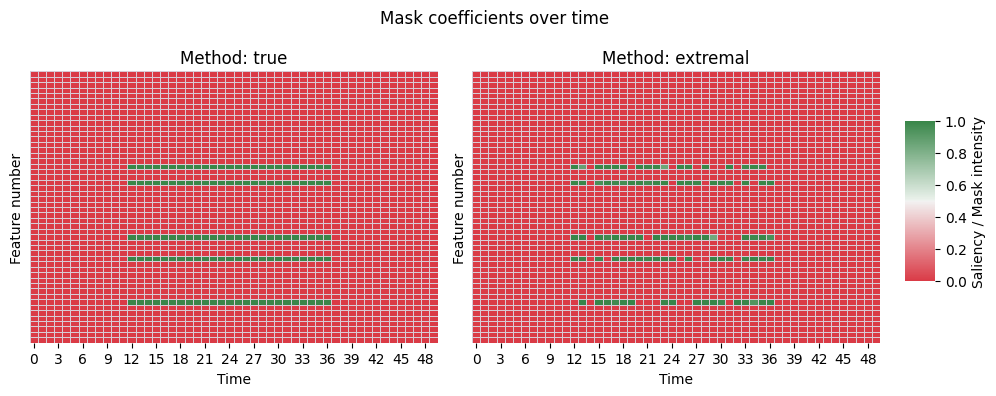

In [ ]:
SAL_ID = 100  # Which sample to investigate?
saliencies = {
    "true": true_saliency_arma[SAL_ID].T,
    "extremal": extremal_attr_arma[SAL_ID].T,
}
plot_heatmap(saliencies)

### Visualize perturbations - ARMA

In [ ]:
arma_batch, perturbation_arma, mask_arma, x1_arma, x2_arma = compute_perturbations(
    inputs_arma, extremal_mask_net_arma, perturb_net=None, batch_idx=0
)

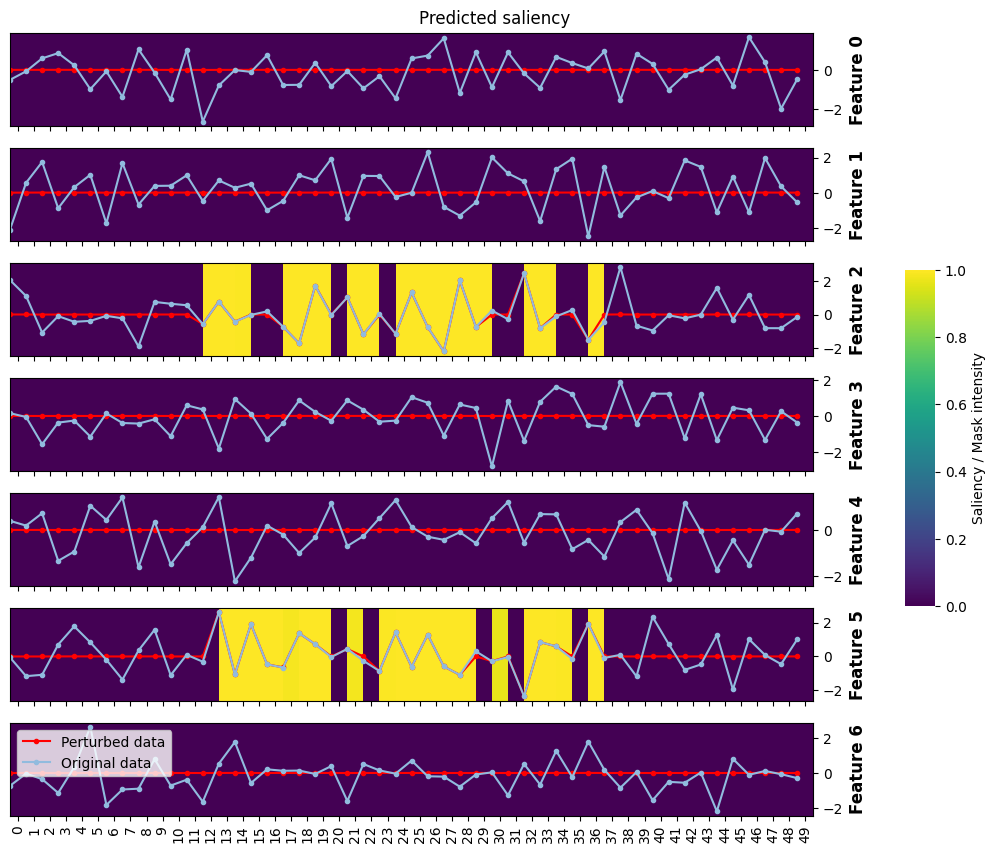

In [ ]:
sample_id = 2  # Which sample to investigate?
FROM = 15  # From which time series
TO = 22  # to which time series to plot?
plot_saliency(
    arma_batch[sample_id].T[FROM:TO],
    x1_arma[sample_id].T[FROM:TO],
    mask_arma[sample_id].T[FROM:TO],
    suptitle="Predicted saliency",
)

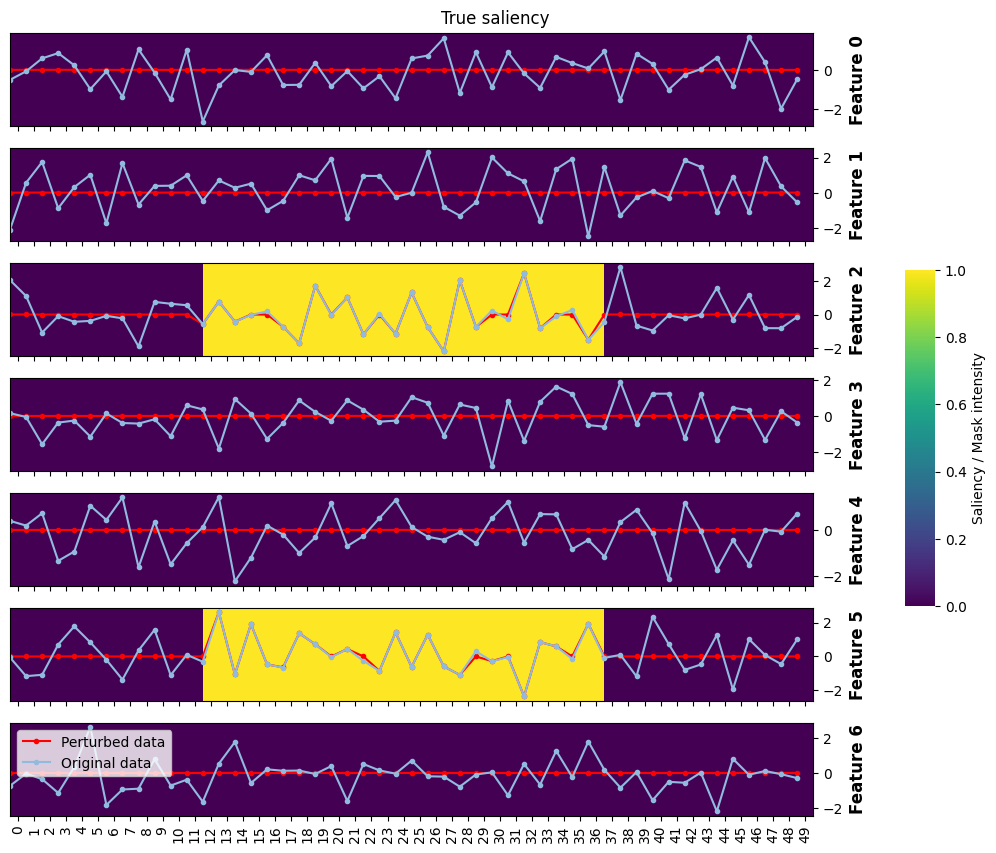

In [ ]:
plot_saliency(
    arma_batch[sample_id].T[FROM:TO],
    x1_arma[sample_id].T[FROM:TO],
    true_saliency_arma[sample_id].T[FROM:TO],
    suptitle="True saliency",
)

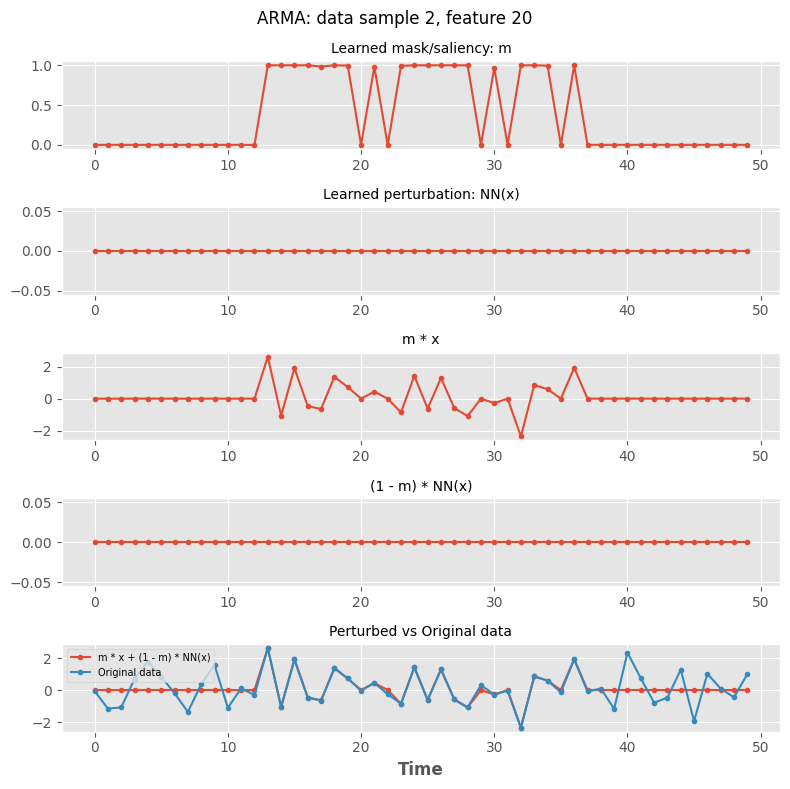

In [ ]:
sample_id = 2  # Which sample to investigate?
feat_no = 20  # Which specific time series to investigate?
plot_components(
    orig=arma_batch[sample_id].T[feat_no],
    perturbed=x1_arma[sample_id].T[feat_no],
    mask=mask_arma[sample_id].T[feat_no],
    perturbation=perturbation_arma[sample_id].T[feat_no],
    suptitle=f"ARMA: data sample {sample_id}, feature {feat_no}",
    figsize=(8, 8),
)

## HMM

0. (DONE) Train the HMM model with experiments.utils.import (with few epochs first!)
00. (DONE) Load the model from this directory
000. (DONE) Visualize the alternative metric with inverted stuff
1. (DONE) Investigate calculated metrics - why am I not getting AUP=~1 for HMM trained on 500 epochs?
2. (DONE) Make sure the correct model is loaded and it works
3. (DONE) Update all visualizations for these models
4. (DONE) Load models for MIMIC3
5. Can I reproduce their metrics?
6. (DONE) Update all visualizations for MIMIC3
7. Reproduce Figure 5
8. Use the alternative saliency. Do the conclusions change looking at the plots and figure 5-inspired plot?
9. Load more models for visualization

Additional ideas:
- clamping vs normalizing in the paper?? relative importance
- figure 5 - uniform distribution (all points equally important),
- more important to weight the events at the end of the signal

HMM model training and visualization procedure:
1. Retrain the networks with seed 42 and deterministic
2. Save them via pickle
3. When loading the model, make sure to 
```python
import pickle
from experiments.hmm.classifier import StateClassifier, StateClassifierNet
```

## Method 1 (shorter)

In [100]:
# Load HMM data
from tint.datasets import HMM

# Load only the test data because the classifier was trained on train part
# but the mask net and explainer was trained on the test part to explain the
# classifier's decision
# hmm.download(split="train")
# x_train = hmm.preprocess(split="train")["x"]

# Make sure to seed before data generation to return numpy and other libraries to their original state
# in order to generate the same data with the same seed as the process for training the models
seed_everything(seed=SEED, workers=True)

FOLD = 1

hmm = HMM(n_folds=5, fold=FOLD, seed=SEED)
hmm.download(split="test")
inputs_hmm = hmm.preprocess(split="test")["x"]
y_hmm = hmm.preprocess(split="test")["y"]
true_saliency_hmm = hmm.true_saliency(split="test")
print("batch size, time series length, no. features", inputs_hmm.size())

Seed set to 42


/home/paulius/personal/pycharm-projects/factai/tint/data/hmm
batch size, time series length, no. features torch.Size([200, 200, 3])


In [113]:
def get_model(
    trainer,
    model,
    model_name,
    data_name,
    seed,
    fold,
    train_dataloaders=None,
    datamodule=None,
    lambda_1=None,
    lambda_2=None,
    retrain=False,
    preservation_mode=True,
):
    checkpoint_dir = "experiments/checkpoints"

    if model_name != "extremal_mask":
        checkpoint_path = (
            f"{checkpoint_dir}/{data_name}_{model_name}_{seed}_{fold}.ckpt"
        )
    elif model_name == "extremal_mask" and (lambda_1 is None or lambda_2 is None):
        raise ValueError(
            "must specify lambda 1 and lambda 2 values for extremal mask explainer"
        )
    else:
        if preservation_mode:
            checkpoint_path = f"{checkpoint_dir}/{data_name}_{model_name}_{seed}_{lambda_1}_{lambda_2}_{fold}.ckpt"
        else:
            checkpoint_path = f"{checkpoint_dir}/{data_name}_{model_name}_{seed}_{lambda_1}_{lambda_2}_{fold}_deletion.ckpt"

    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    if os.path.exists(checkpoint_path) and not retrain:
        model.load_state_dict(th.load(checkpoint_path))
        print(
            f"{model_name} has loaded the saved weights on {data_name} dataset with fold = {fold}, if applicable, lambda 1 = {lambda_1} and lambda 2 = {lambda_2}."
        )
    else:
        # Fit and retain training
        if datamodule is not None and train_dataloaders is not None:
            trainer.fit(
                model, train_dataloaders=train_dataloaders, datamodule=datamodule
            )
        # GRU classifier training
        elif datamodule is not None:
            trainer.fit(model, datamodule=datamodule)
        # Dyna and extremal mask training
        elif train_dataloaders is not None:
            trainer.fit(model, train_dataloaders=train_dataloaders)
        else:
            raise Exception()

        th.save(model.state_dict(), checkpoint_path)

    return model

In [102]:
from tint.attr.models import ExtremalMaskNet
import torch.nn as nn
from tint.models import RNN, MLP

classifier_hmm = StateClassifierNet(
    feature_size=3,
    n_state=2,
    hidden_size=200,
    regres=True,
    loss="cross_entropy",
    lr=0.0001,
    l2=1e-3,
)

classifier_mimic = get_model(
    trainer=None,
    model=classifier_mimic,
    model_name="classifier",
    data_name="hmm",
    seed=SEED,
    fold=FOLD,
    datamodule=None,
)
classifier_hmm.eval()

extremal_mask_net_hmm = ExtremalMaskNet(
    forward_func=classifier_hmm,
    model=nn.Sequential(
        RNN(
            input_size=inputs_hmm.shape[-1],
            rnn="gru",
            hidden_size=inputs_hmm.shape[-1],
            bidirectional=True,
        ),
        MLP([2 * inputs_hmm.shape[-1], inputs_hmm.shape[-1]]),
    ),
    lambda_1=1.0,
    lambda_2=1.0,
    optim="adam",
    lr=0.01,
)
checkpoint_path = (
    f"experiments/checkpoints/hmm_extremal_mask_{SEED}_1.0_1.0_{FOLD}.ckpt"
)

# Make sure the mask is initialized
extremal_mask_net_hmm.net.init(input_size=inputs_hmm.shape, batch_size=100)
extremal_mask_net_hmm.load_state_dict(th.load(checkpoint_path))

# Compute the attributions using the loaded network
extremal_mask_net_hmm.eval()
extremal_attr_hmm = extremal_mask_net_hmm.net.representation()

classifier has loaded the saved weights on hmm dataset with fold = 1, if applicable, lambda 1 = None and lambda 2 = None.


In [103]:
from tint.metrics.white_box import aup, aur, rmse, information, entropy

print(f"AUP: {aup(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"AUR: {aur(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"RMSE: {rmse(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"Information: {information(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"Entropy: {entropy(extremal_attr_hmm, true_saliency_hmm):.4}")

AUP: 0.5133
AUR: 0.4386
RMSE: 0.5531
Information: 1.683e+05
Entropy: 5.348e+03


## Method 2 (longer, using the whole main.py approach)

In [96]:
from tint.attr import ExtremalMask
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer
import random

# try for both devices as well
device = "cpu"
dataset_name = "hmm"
deterministic = True
seed = 42
fold = 1
lambda_1 = 1.0
lambda_2 = 1.0
retrain = False

In [97]:
# If deterministic, seed everything
if deterministic:
    seed_everything(seed=seed, workers=True)

# Get accelerator and device
accelerator = device.split(":")[0]
device_id = 1
if len(device.split(":")) > 1:
    device_id = [int(device.split(":")[1])]

hmm = HMM(n_folds=5, fold=fold, seed=seed)

x_train = hmm.preprocess(split="train")["x"].to(device)
x_test = hmm.preprocess(split="test")["x"].to(device)
y_test = hmm.preprocess(split="test")["y"].to(device)
true_saliency = hmm.true_saliency(split="test").to(device)

Seed set to 42


/home/paulius/personal/pycharm-projects/factai/tint/data/hmm


In [98]:
# Create classifier
classifier = StateClassifierNet(
    feature_size=3,
    n_state=2,
    hidden_size=200,
    regres=True,
    loss="cross_entropy",
    lr=0.0001,
    l2=1e-3,
)

trainer = Trainer(
    max_epochs=50,
    accelerator=accelerator,
    devices=device_id,
    log_every_n_steps=2,
    deterministic=deterministic,
    logger=TensorBoardLogger(
        save_dir=".",
        version=random.getrandbits(128),
    ),
)

classifier = get_model(
    trainer,
    classifier,
    "classifier",
    dataset_name,
    seed,
    fold,
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    datamodule=hmm,
    retrain=retrain,
)

# Switch to eval
classifier.eval()

# Set model to device
classifier.to(device)

trainer = Trainer(
    max_epochs=500,
    accelerator=accelerator,
    devices=device_id,
    log_every_n_steps=2,
    deterministic=deterministic,
    logger=TensorBoardLogger(
        save_dir=".",
        version=random.getrandbits(128),
    ),
)
mask = ExtremalMaskNet(
    forward_func=classifier,
    model=nn.Sequential(
        RNN(
            input_size=x_test.shape[-1],
            rnn="gru",
            hidden_size=x_test.shape[-1],
            bidirectional=True,
        ),
        MLP([2 * x_test.shape[-1], x_test.shape[-1]]),
    ),
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    optim="adam",
    lr=0.01,
)
explainer = ExtremalMask(dataset_name, classifier, seed, fold)
extremal_attr_hmm = explainer.attribute(
    x_test,
    additional_forward_args=(True,),
    trainer=trainer,
    mask_net=mask,
    batch_size=100,
    retrain=retrain,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


classifier has loaded the saved weights on hmm dataset with fold = 1, if applicable, lambda 1 = 1.0 and lambda 2 = 1.0.
extremal_mask has loaded the saved weights on hmm dataset with, if applicable, lambda 1 = 1.0 and lambda 2 = 1.0.


In [99]:
from tint.metrics.white_box import aup, aur, rmse, information, entropy

print(f"AUP: {aup(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"AUR: {aur(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"RMSE: {rmse(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"Information: {information(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"Entropy: {entropy(extremal_attr_hmm, true_saliency_hmm):.4}")

AUP: 0.5133
AUR: 0.4386
RMSE: 0.5531
Information: 1.683e+05
Entropy: 5.348e+03


## STOP HERE

In [ ]:
# Load models trained on HMM data
(
    extremal_attr_hmm2,
    extremal_mask_net_hmm2,
    extremal_explainer_hmm2,
    perturbation_net_hmm2,
    _,
) = load_explainer(explainer_name="42_hmm_extremal2")

# Switch to eval
# classifier_hmm2.eval()
print()

In [ ]:
from tint.metrics.white_box import aup, aur, rmse, information, entropy

print(f"AUP: {aup(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"AUR: {aur(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"RMSE: {rmse(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"Information: {information(extremal_attr_hmm, true_saliency_hmm):.4}")
print(f"Entropy: {entropy(extremal_attr_hmm, true_saliency_hmm):.4}")

AUP: 0.5133
AUR: 0.4386
RMSE: 0.5531
Information: 1.683e+05
Entropy: 5.348e+03


In [ ]:
from tint.metrics.white_box import aup, aur, rmse, information, entropy

print(f"AUP: {aup(extremal_attr_hmm2, true_saliency_hmm):.4}")
print(f"AUR: {aur(extremal_attr_hmm2, true_saliency_hmm):.4}")
print(f"RMSE: {rmse(extremal_attr_hmm2, true_saliency_hmm):.4}")
print(f"Information: {information(extremal_attr_hmm2, true_saliency_hmm):.4}")
print(f"Entropy: {entropy(extremal_attr_hmm2, true_saliency_hmm):.4}")

AUP: 0.7602
AUR: 0.6592
RMSE: 0.364
Information: 1.06e+05
Entropy: 1.865e+04


### Visualize explanation performance - HMM

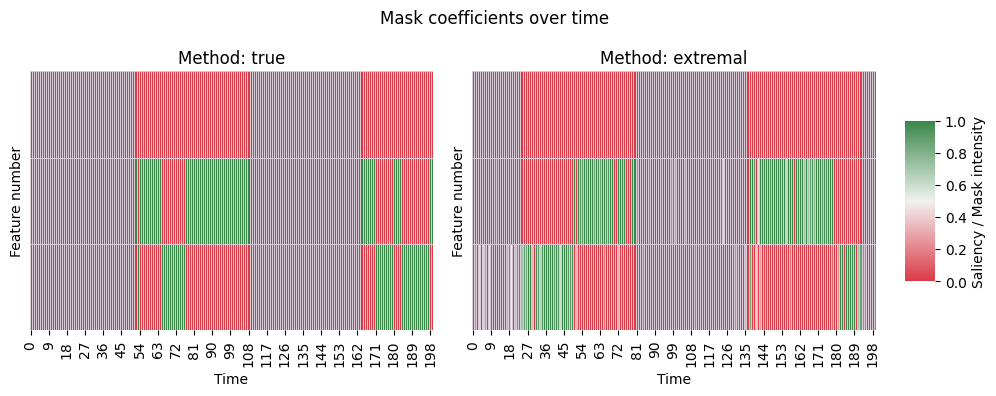

In [ ]:
# Visualize true and predicted saliency
SAL_ID = 11
saliencies = {
    "true": true_saliency_hmm[SAL_ID].T,
    "extremal": extremal_attr_hmm[SAL_ID].T,
}
plot_heatmap(saliencies)

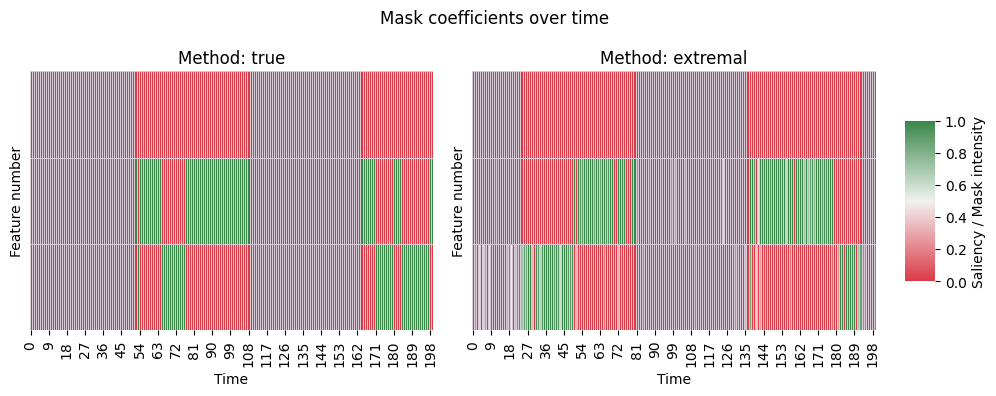

In [ ]:
# Visualize true and predicted saliency
SAL_ID = 11
saliencies = {
    "true": true_saliency_hmm[SAL_ID].T,
    "extremal": extremal_attr_hmm[SAL_ID].T,
}
plot_heatmap(saliencies)

### Visualize learned perturbations - HMM

In [ ]:
# def compute_perturbations(
#     data, mask_net, perturb_net=None, batch_idx: int = 0
# ) -> (th.Tensor, th.Tensor, th.Tensor, th.Tensor, th.Tensor):

# x, NN(x), m, x * m + (1 - m) * NN(x), x * (1 - m) + m * NN(x)
hmm_batch, perturbation_hmm, mask_hmm, x1_hmm, x2_hmm = compute_perturbations(
    data=inputs_hmm,
    mask_net=extremal_mask_net_hmm,
    perturb_net=extremal_mask_net_hmm.net.model,
    batch_idx=0,
)

In [ ]:
# x, NN(x), m, x * m + (1 - m) * NN(x), x * (1 - m) + m * NN(x)
hmm_batch, perturbation_hmm, mask_hmm, x1_hmm, x2_hmm = compute_perturbations(
    inputs_hmm, extremal_mask_net_hmm2, perturb_net=perturbation_net_hmm2, batch_idx=0
)

In [ ]:
extremal_attr_hmm[:100]

torch.Size([100, 200, 3])

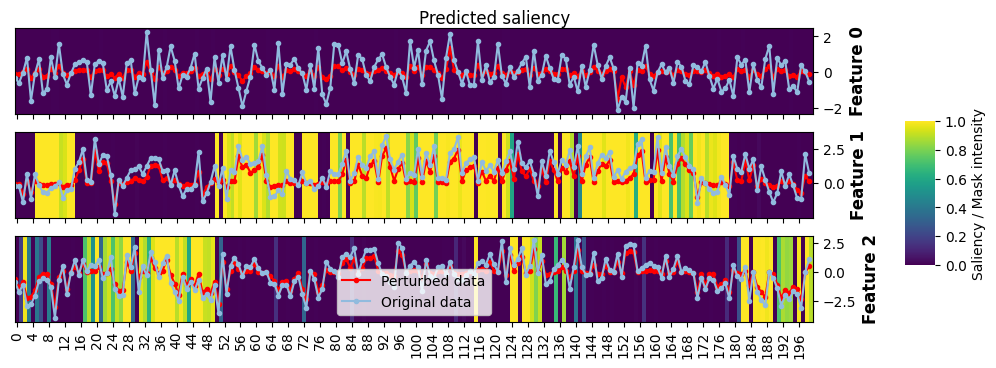

In [ ]:
plot_saliency(
    hmm_batch[SAL_ID].T,
    x1_hmm[SAL_ID].T,
    extremal_attr_hmm[:100][SAL_ID].T,
    suptitle="Predicted saliency",
)

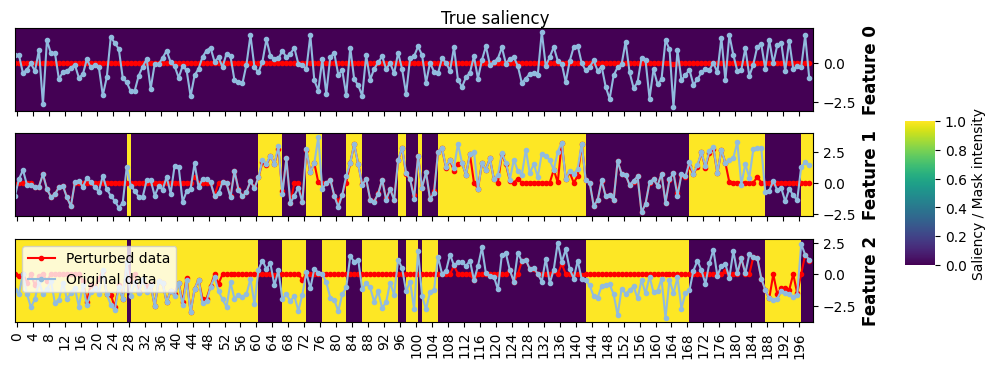

In [ ]:
plot_saliency(
    hmm_batch[SAL_ID].T,
    x1_hmm[SAL_ID].T,
    true_saliency_hmm[SAL_ID].T,
    suptitle="True saliency",
)

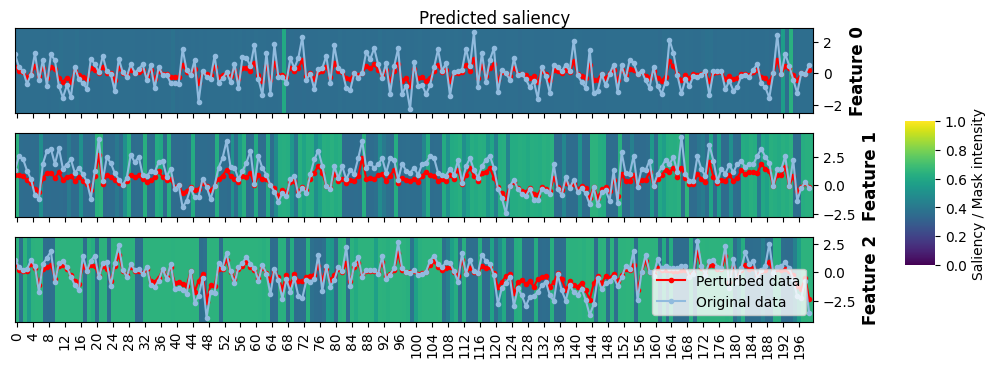

In [ ]:
plot_saliency(
    hmm_batch[SAL_ID].T,
    x1_hmm[SAL_ID].T,
    mask_hmm[SAL_ID].T,
    suptitle="Predicted saliency",
)

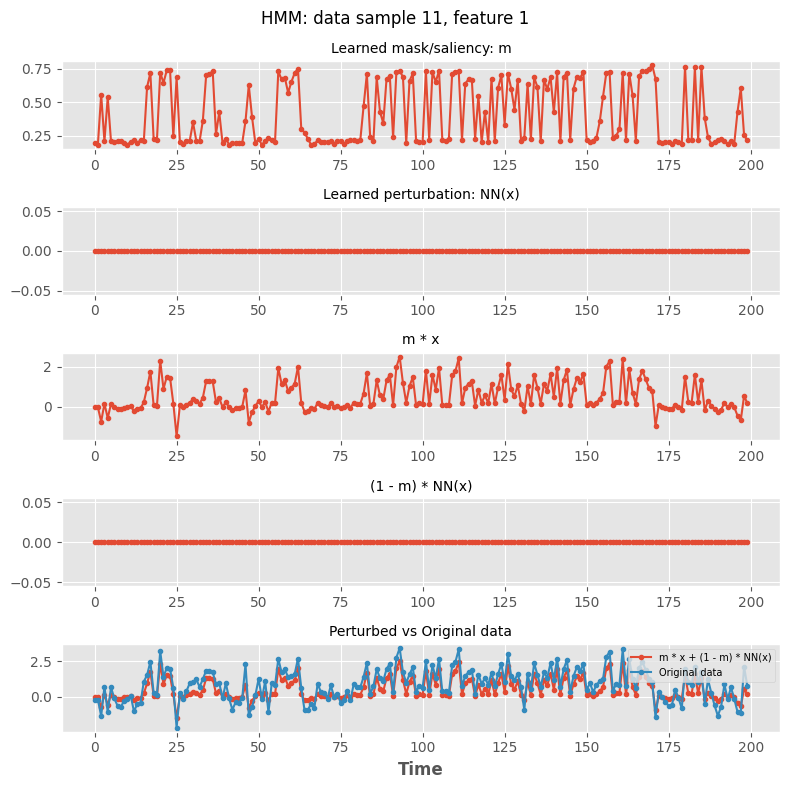

In [ ]:
feat_no = 1  # Which specific time series to investigate?
plot_components(
    orig=hmm_batch[SAL_ID].T[feat_no],
    perturbed=x1_hmm[SAL_ID].T[feat_no],
    mask=mask_hmm[SAL_ID].T[feat_no],
    perturbation=perturbation_hmm[SAL_ID].T[feat_no],
    suptitle=f"HMM: data sample {SAL_ID}, feature {feat_no}",
    figsize=(8, 8),
)

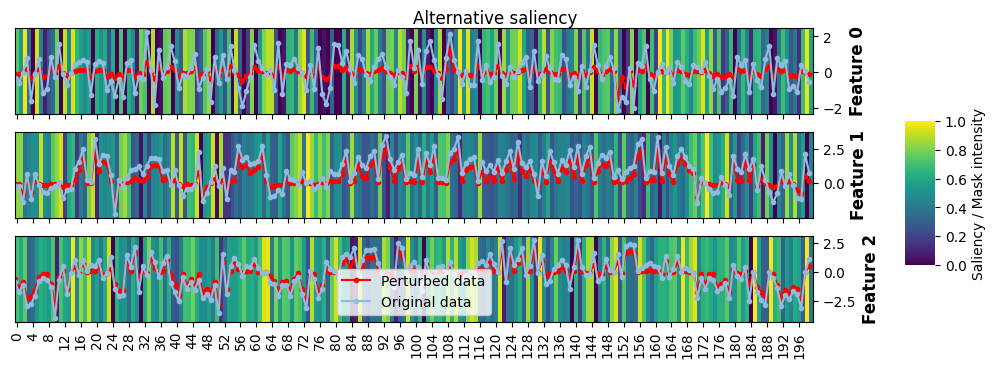

In [ ]:
# 1 - (1 - m) * |NN(x) - x|
# Intuition: the higher this value, the more perturbed the data is.
alternative = 1 - (1 - mask_hmm) * th.abs(perturbation_hmm - hmm_batch)
plot_saliency(
    hmm_batch[SAL_ID].T,
    x1_hmm[SAL_ID].T,
    alternative[SAL_ID].T,
    suptitle="Alternative saliency",
)

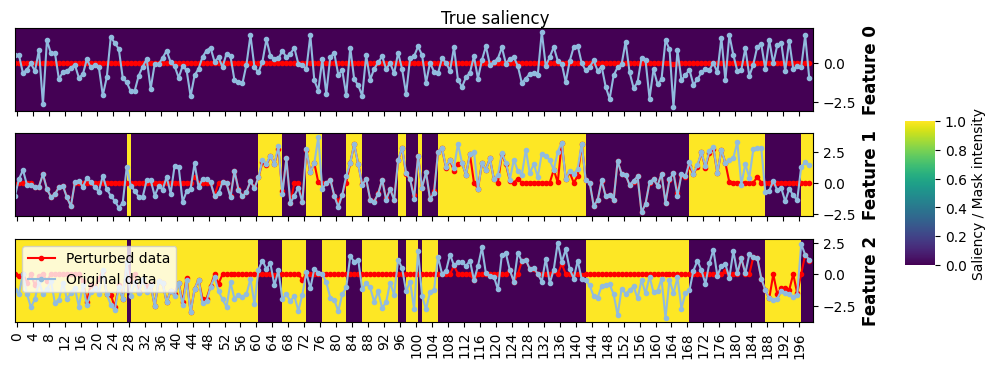

In [ ]:
plot_saliency(
    hmm_batch[SAL_ID].T,
    x1_hmm[SAL_ID].T,
    true_saliency_hmm[SAL_ID].T,
    suptitle="True saliency",
)

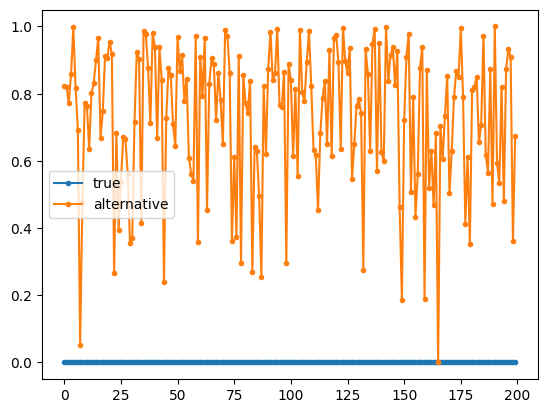

In [ ]:
# plot true saliency vs (1 - m) * |NN(x) - x|
alt_spec = alternative[SAL_ID].T[0]
alternative_normalized = (alt_spec - alt_spec.min()) / (alt_spec.max() - alt_spec.min())
plt.plot(true_saliency_hmm[SAL_ID].T[0], marker=".", label="true")
plt.plot(alternative_normalized, marker=".", label="alternative")
plt.legend()
plt.show()

## MIMIC3

In [107]:
from tint.datasets import Mimic3

FOLD = 0
device = "cpu"

# Load data
mimic3 = Mimic3(n_folds=5, fold=FOLD, seed=SEED)

x_train = mimic3.preprocess(split="train")["x"].to(device)
inputs_mimic = mimic3.preprocess(split="test")["x"].to(device)
true_saliency_mimic = mimic3.preprocess(split="test")["y"].to(device)

In [115]:
from experiments.mimic3.mortality.classifier import MimicClassifierNet


classifier_mimic = MimicClassifierNet(
    feature_size=31,
    n_state=2,
    hidden_size=200,
    regres=True,
    loss="cross_entropy",
    lr=0.0001,
    l2=1e-3,
)

classifier_mimic = get_model(
    trainer=None,
    model=classifier_mimic,
    model_name="classifier",
    data_name="mimic3",
    seed=SEED,
    fold=FOLD,
    datamodule=None,
)
classifier_mimic.eval()
# Set model to device
classifier_mimic.to(device)
print()

classifier has loaded the saved weights on mimic3 dataset with fold = 0, if applicable, lambda 1 = None and lambda 2 = None.



In [116]:
extremal_mask_net_mimic = ExtremalMaskNet(
    forward_func=classifier_mimic,
    model=nn.Sequential(
        RNN(
            input_size=inputs_mimic.shape[-1],
            rnn="gru",
            hidden_size=inputs_mimic.shape[-1],
            bidirectional=True,
        ),
        MLP([2 * inputs_mimic.shape[-1], inputs_mimic.shape[-1]]),
    ),
    lambda_1=1.0,
    lambda_2=1.0,
    optim="adam",
    lr=0.01,
)
checkpoint_path = (
    f"experiments/checkpoints/mimic3_extremal_mask_{SEED}_1.0_1.0_{FOLD}.ckpt"
)

# Make sure the mask is initialized
extremal_mask_net_mimic.net.init(input_size=inputs_mimic.shape, batch_size=100)
extremal_mask_net_mimic.load_state_dict(th.load(checkpoint_path))

# Compute the attributions using the loaded network
extremal_mask_net_mimic.eval()
extremal_attr_mimic = extremal_mask_net_mimic.net.representation()

In [119]:
mimic_batch, perturbation_mimic, mask_mimic, x1_mimic, x2_mimic = compute_perturbations(
    data=inputs_mimic,
    mask_net=extremal_mask_net_mimic,
    perturb_net=extremal_mask_net_mimic.net.model,
    batch_idx=0,
)

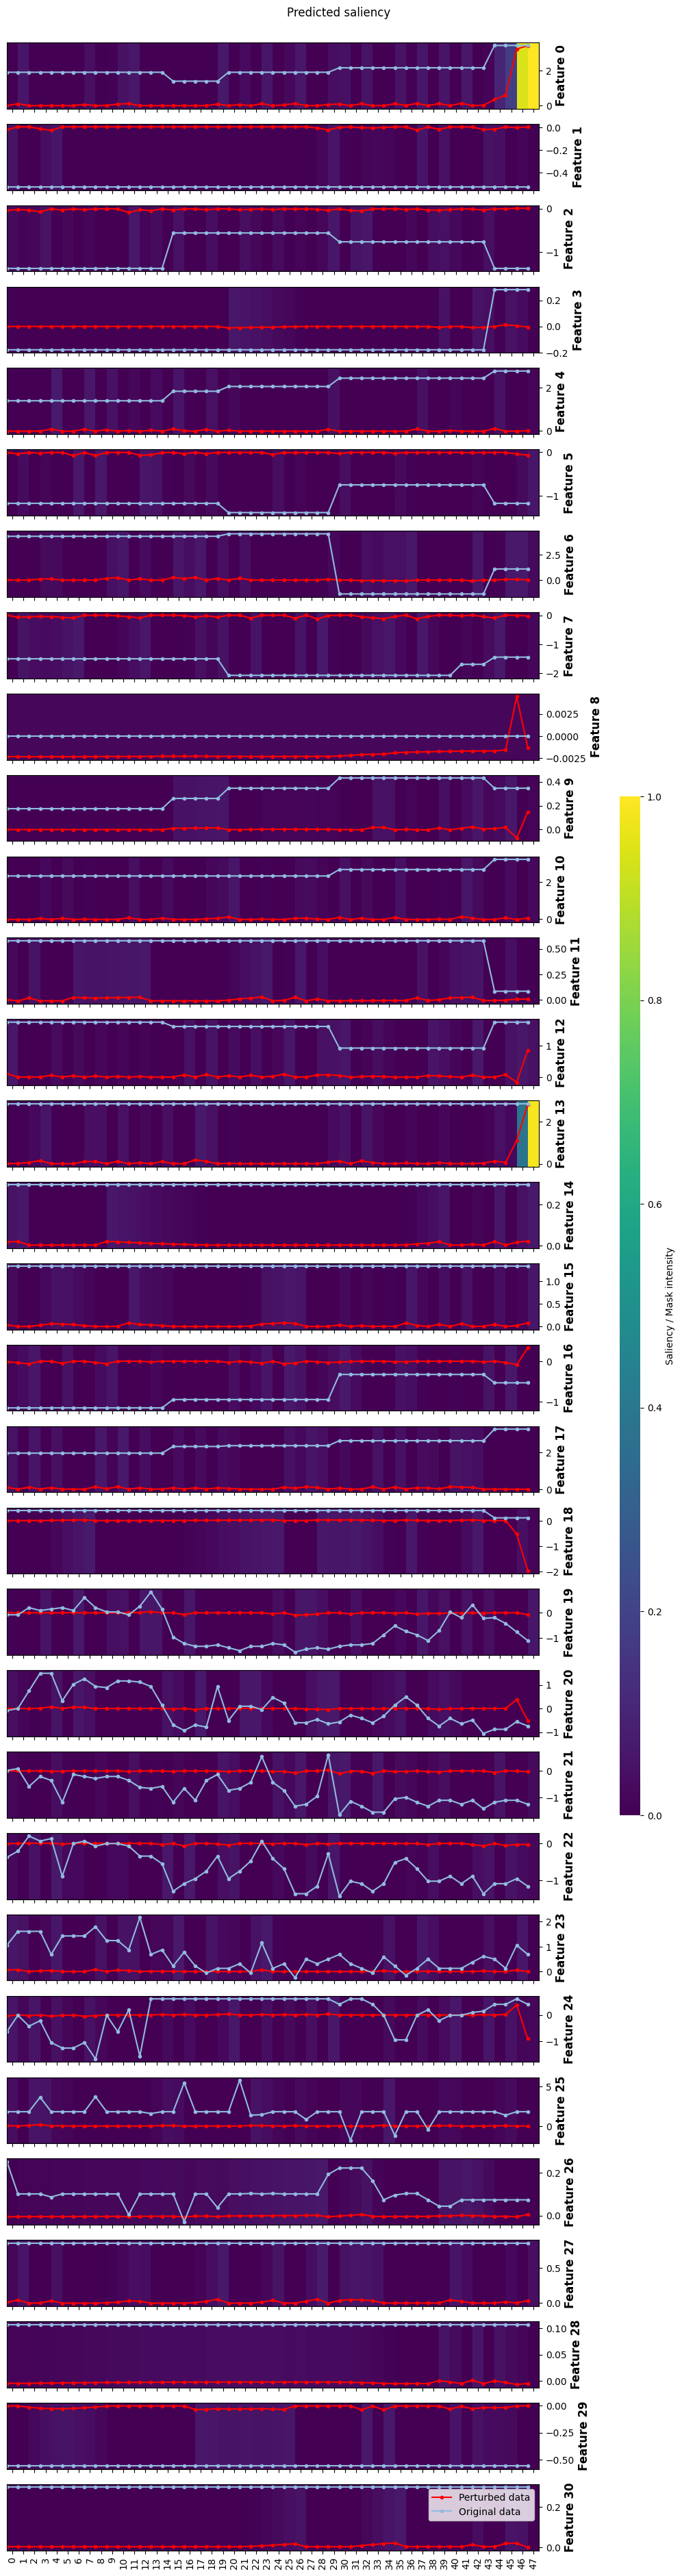

In [121]:
SAL_ID = 12
plot_saliency(
    mimic_batch[SAL_ID].T,
    x1_mimic[SAL_ID].T,
    extremal_attr_mimic[:100][SAL_ID].T,
    suptitle="Predicted saliency",
)

In [ ]:
# TODO: Visualize all trained methods on MIMIC dataset
SAL_ID = 11
saliencies = {
    "extremal": extremal_attr_mimic[SAL_ID].T,
    "dynamask": extremal_attr_mimic[SAL_ID].T,
    "fit": extremal_attr_mimic[SAL_ID].T,
    "retain": extremal_attr_mimic[SAL_ID].T,
    "fit": extremal_attr_mimic[SAL_ID].T,
}
plot_heatmap(saliencies)

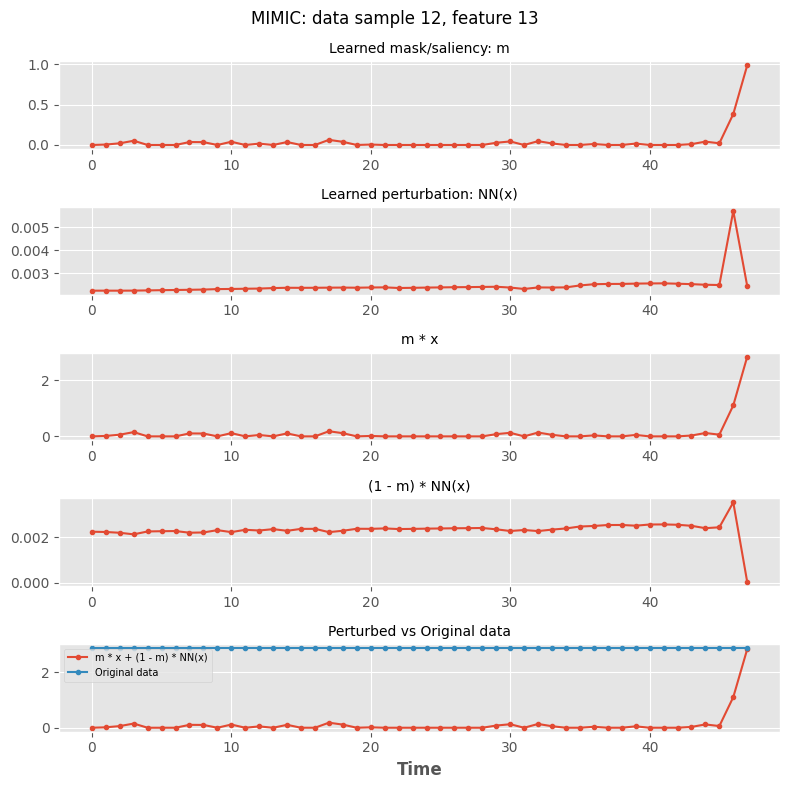

In [122]:
feat_no = 13  # Which specific time series to investigate?
plot_components(
    orig=mimic_batch[SAL_ID].T[feat_no],
    perturbed=x1_mimic[SAL_ID].T[feat_no],
    mask=mask_mimic[SAL_ID].T[feat_no],
    perturbation=perturbation_mimic[SAL_ID].T[feat_no],
    suptitle=f"MIMIC: data sample {SAL_ID}, feature {feat_no}",
    figsize=(8, 8),
)

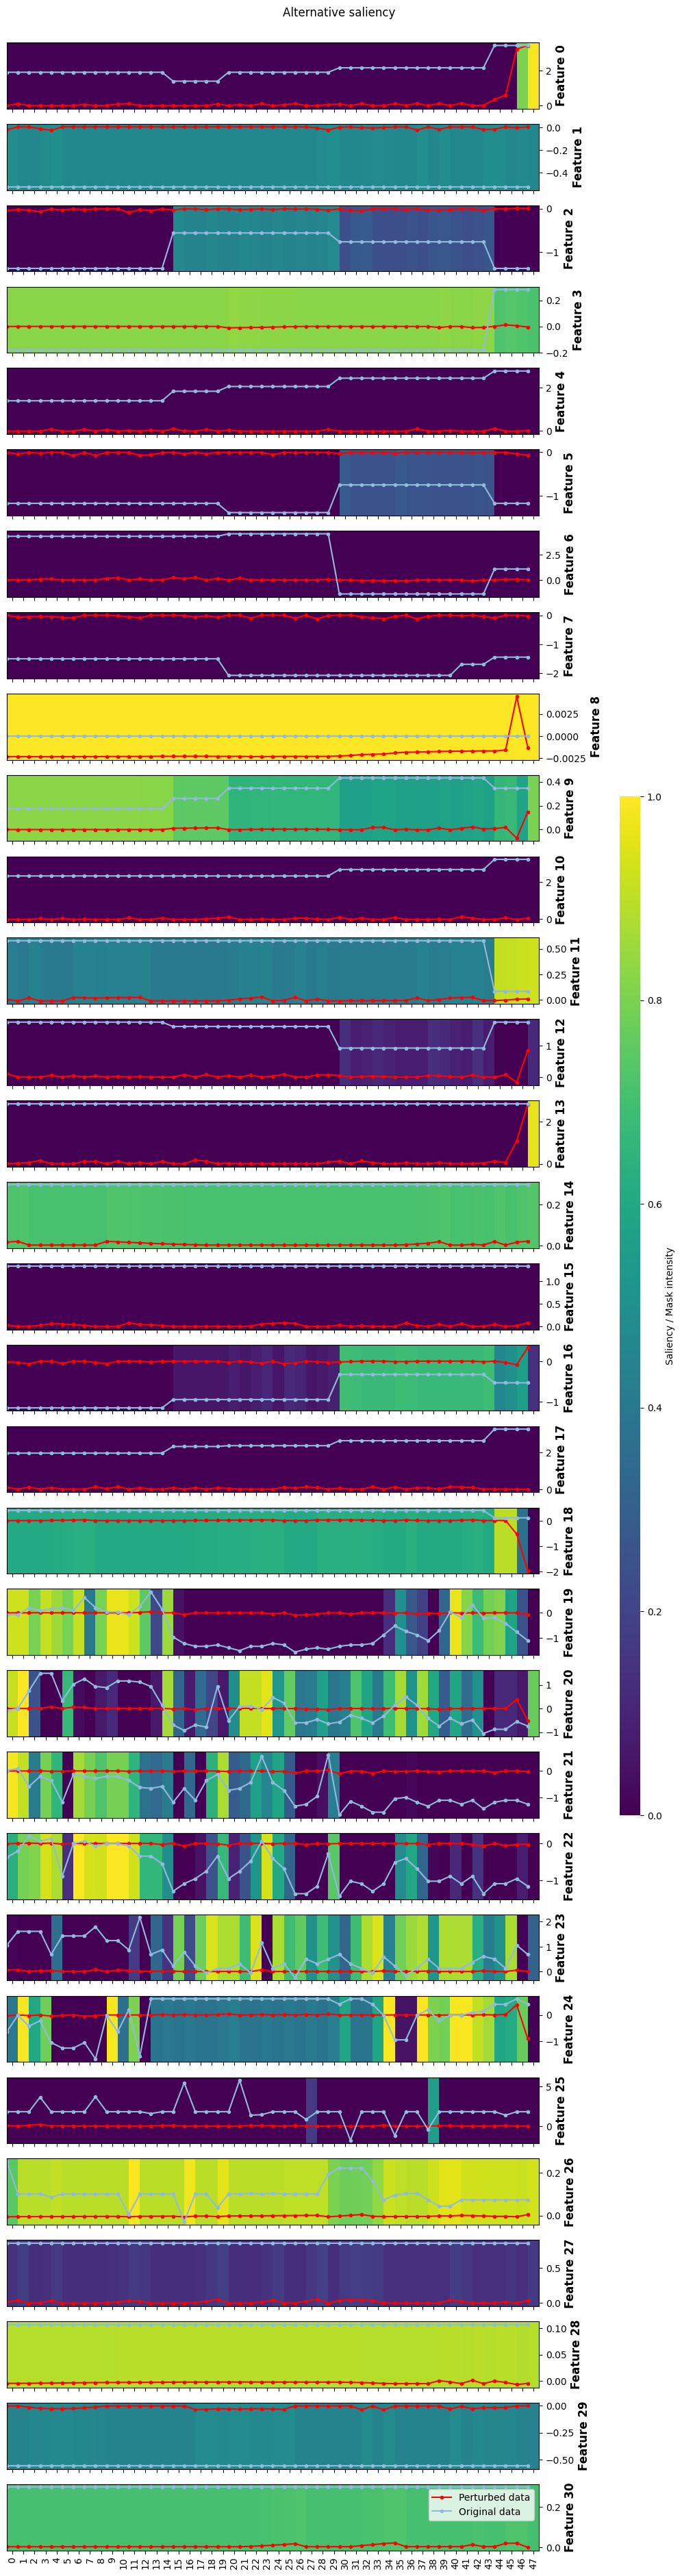

In [123]:
# 1 - (1 - m) * |NN(x) - x|
# Intuition: the higher this value, the more perturbed the data is.
alternative_mimic = 1 - (1 - mask_mimic) * th.abs(perturbation_mimic - mimic_batch)
plot_saliency(
    mimic_batch[SAL_ID].T,
    x1_mimic[SAL_ID].T,
    alternative_mimic[SAL_ID].T,
    suptitle="Alternative saliency",
)

### Reproducing Figure 5

In [220]:
# inp = th.arange(1, 201).reshape((10, 5, 4)).float()
# np.arange(4, 204, 4).mean()
# inp[0]
# th.mean(inp, dim=(0, 1))

In [326]:
# Filter data to postive (dead) patients
indices = th.nonzero(true_saliency_mimic).reshape(-1)
dead_attr = extremal_attr_mimic[indices]

In [327]:
dead_attr.shape

torch.Size([414, 48, 31])

In [328]:
attr_means = th.mean(dead_attr, dim=(0, 1))

In [329]:
means_over_time = []
# Compute means per time series (or feature)
for patient in extremal_attr_mimic:
    means_over_time.append(patient.mean(axis=0))

means_over_time = np.array(means_over_time)
# Compute means and confidence intervals

In [330]:
from scipy.stats import t

alpha = 0.95
feature_means = []
feature_err = []
for feature in means_over_time.T:
    feature_means.append(feature.mean())
    conf_interval = t.interval(
        confidence=alpha,
        df=len(feature) - 1,
        loc=np.mean(feature),
        scale=np.std(feature) / np.sqrt(len(feature)),
    )
    feature_err.append(conf_interval)

feature_means = np.array(feature_means)
feature_err = np.array(feature_err)

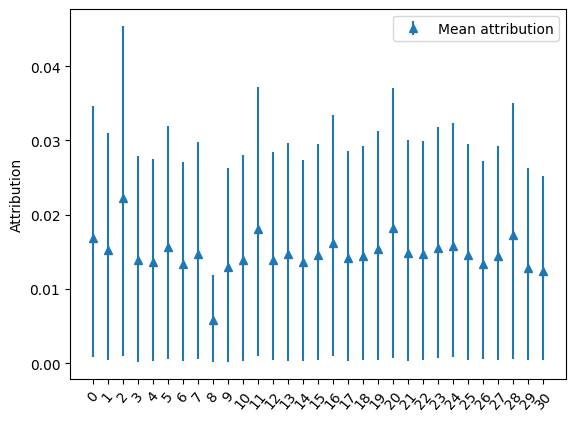

In [334]:
xs = np.arange(len(feature_means))
plt.errorbar(xs, feature_means, yerr=feature_err.T, fmt="^", label="Mean attribution")
plt.ylabel("Attribution")
plt.xticks(xs, rotation=50)
plt.legend()
plt.show()